# Notebook Imports

In [1]:
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.linear_model import SGDRegressor
from sklearn.datasets import load_boston
from sklearn.datasets import make_regression
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
import plotly.graph_objects as go
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score



import warnings
warnings.filterwarnings("ignore")


try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
    
%matplotlib inline  

# Data Imports

In [ ]:
building_meta = pd.read_csv('./dataset/building_metadata.csv')
weather_train = pd.read_csv('./dataset/weather_train.csv')
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')
weather_test = pd.read_csv('./dataset/weather_test.csv')
submission = pd.read_csv('./dataset/sample_submission.csv')

## Converting all dataframes timestamp column into datetime objects.

In [ ]:
#convert all timestamp to datetime
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])


# Building Meta data
###### We will find out how many feature variables and their distributions

In [ ]:
building_meta.head(10)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
5,0,5,Education,8000,2000.0,NaN
6,0,6,Lodging/residential,27926,1981.0,NaN
7,0,7,Education,121074,1989.0,NaN
8,0,8,Education,60809,2003.0,NaN
9,0,9,Office,27000,2010.0,NaN


In [ ]:
building_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [ ]:
nrows,ncolumns = building_meta.shape

In [ ]:
#Here we check for any null values
nullInYearBuilt = (building_meta['year_built'].isnull().sum())/nrows*100
print (nullInYearBuilt)
nullInFloorCount = (building_meta['floor_count']).isnull().sum()/nrows*100
print (nullInFloorCount)
#We see that about 53.4% of data in year_built are null and 75% in floor_count
#This makes these two features difficult to use later on.

53.41614906832298
75.50034506556246


## The following section will be devoted to filling the floor count attribute in the trainNoOutlier dataframe as this feature had the second highest correlation with total meter readings

In this section we will try to fill the floor count feature thorugh spliting the dataframe into several dataframes based on the primary use feature, then each dataframe will be clustered and the floor count will be filled with the average floor count of the cluster or the floor count of the nearest neighbour in the cluster

In [ ]:
arr = building_meta.primary_use.unique()

In [ ]:
# KNN imputer to fill in missing values in floor_count
# First we define a subset of the dataframe and encode the primary_use column
primary_use_list_KNN = building_meta.primary_use.unique()
encoder = OneHotEncoder(handle_unknown='ignore')
building_meta[primary_use_list_KNN] = encoder.fit_transform(building_meta['primary_use'].values.reshape(-1,1)).toarray()
building_meta_subset = building_meta[['site_id', 'square_feet', 'floor_count', 'Education', 'Entertainment/public assembly', 'Food sales and service', 'Healthcare', 'Lodging/residential', 'Manufacturing/industrial', 'Office', 'Other', 'Parking', 'Public services', 'Religious worship', 'Retail', 'Services', 'Technology/science', 'Utility', 'Warehouse/storage']]
building_meta_subset['square_feet'] = building_meta_subset['square_feet'] * 0.092903 #convert square feet to square meters
building_meta_subset.head()


,site_id,square_feet,floor_count,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
0,0,690.455096,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,252.696160,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,499.446528,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2200.407555,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,10833.140121,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
building_meta_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   site_id                        1449 non-null   int64  
 1   square_feet                    1449 non-null   float64
 2   floor_count                    355 non-null    float64
 3   Education                      1449 non-null   float64
 4   Entertainment/public assembly  1449 non-null   float64
 5   Food sales and service         1449 non-null   float64
 6   Healthcare                     1449 non-null   float64
 7   Lodging/residential            1449 non-null   float64
 8   Manufacturing/industrial       1449 non-null   float64
 9   Office                         1449 non-null   float64
 10  Other                          1449 non-null   float64
 11  Parking                        1449 non-null   float64
 12  Public services                1449 non-null   f

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range= (0,1))
building_meta_subset_scaled = scaler.fit_transform(building_meta_subset)
building_meta_subset_scaled = pd.DataFrame(building_meta_subset_scaled, columns=building_meta_subset.columns)

In [ ]:
# KNN imputing
imputer = KNNImputer(n_neighbors=5)
building_meta_subset_scaled_imputed = pd.DataFrame(imputer.fit_transform(building_meta_subset_scaled), columns=building_meta_subset.columns)

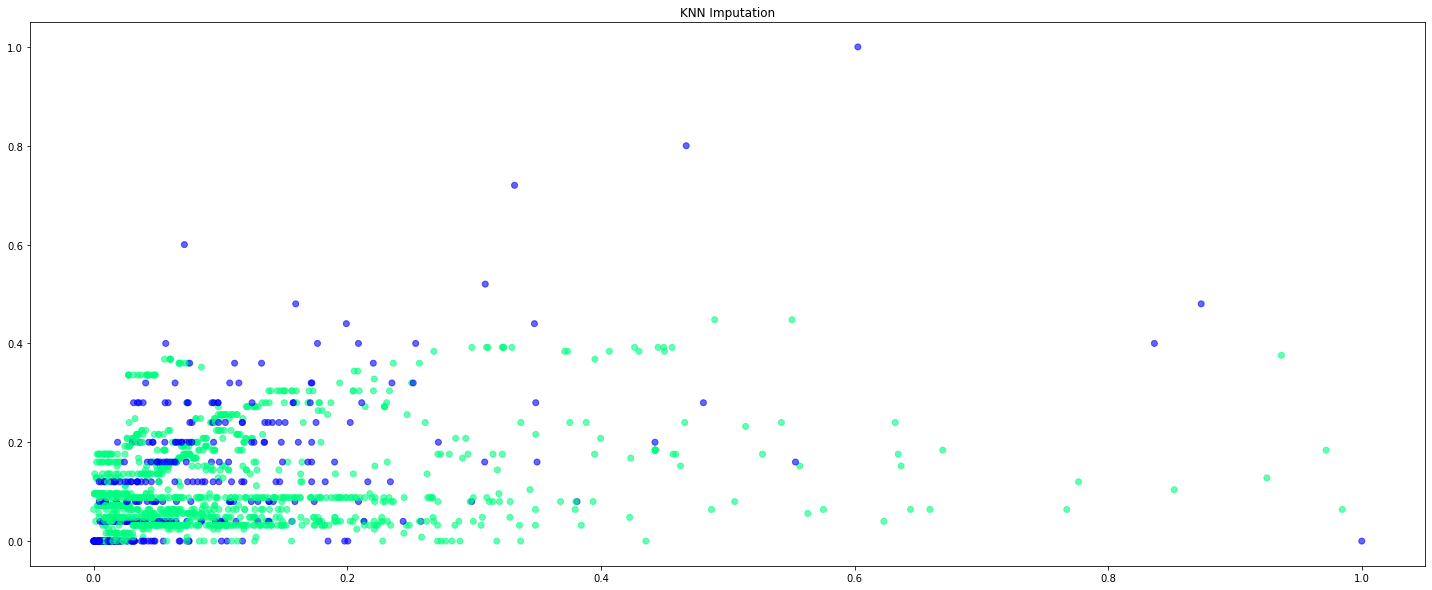

In [ ]:
nulls = building_meta.floor_count.isnull()
plt.figure(figsize=(25,10))
plt.title('KNN Imputation')
plt.scatter(building_meta_subset_scaled_imputed['square_feet'], building_meta_subset_scaled_imputed['floor_count'], c=nulls, cmap='winter', alpha= 0.6)

In [ ]:
building_meta_subset_scaled_imputed = scaler.inverse_transform(building_meta_subset_scaled_imputed)
building_meta_subset_scaled_imputed = pd.DataFrame(building_meta_subset_scaled_imputed, columns=building_meta_subset.columns)
#approximating the floor count to the nearest integer
building_meta_subset_scaled_imputed['floor_count'] = building_meta_subset_scaled_imputed['floor_count'].apply(lambda x: round(x))
building_meta_subset_scaled_imputed.head()

,site_id,square_feet,floor_count,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
0,0.0,690.455096,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,252.696160,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,499.446528,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2200.407555,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,10833.140121,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Now that the floor count variable is filled let's add its values to the original building_meta dataframe

In [ ]:
# repairing the original building_meta dataframe
building_meta['floor_count'] = building_meta_subset_scaled_imputed['floor_count']
# lets drop the encoding for the primary_use column in order to simplify the dataframe and as we will not need it for now
building_meta = building_meta.drop(columns=primary_use_list_KNN)
building_meta.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,5
1,0,1,Education,2720,2004.0,5
2,0,2,Education,5376,1991.0,5
3,0,3,Education,23685,2002.0,6
4,0,4,Education,116607,1975.0,8


## Visualising Data - Historgrams, Distributions and Bar Charts for Building Meta Data

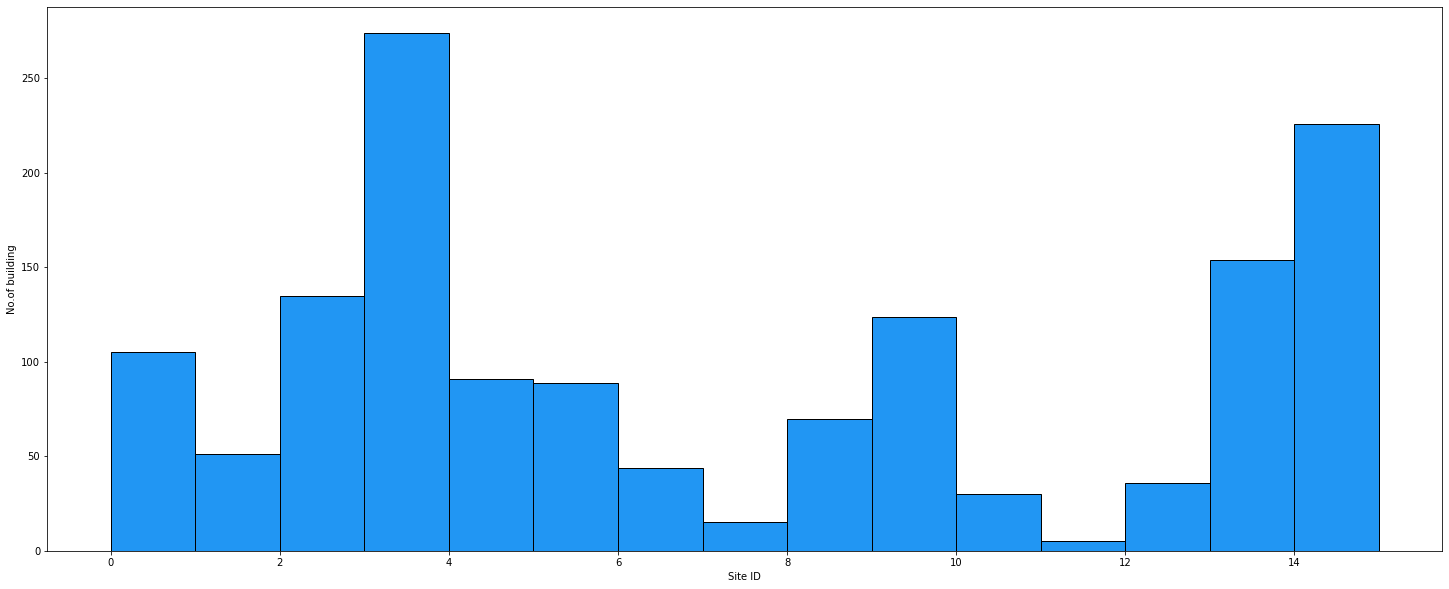

In [ ]:
#Visualize the number of buildings in each site
plt.figure(figsize=[25,10])
plt.hist(building_meta['site_id'], bins=15, ec='black',color="#2196f3")
plt.xlabel('Site ID')
plt.ylabel('No.of building')
plt.show()

<AxesSubplot:xlabel='site_id', ylabel='Density'>

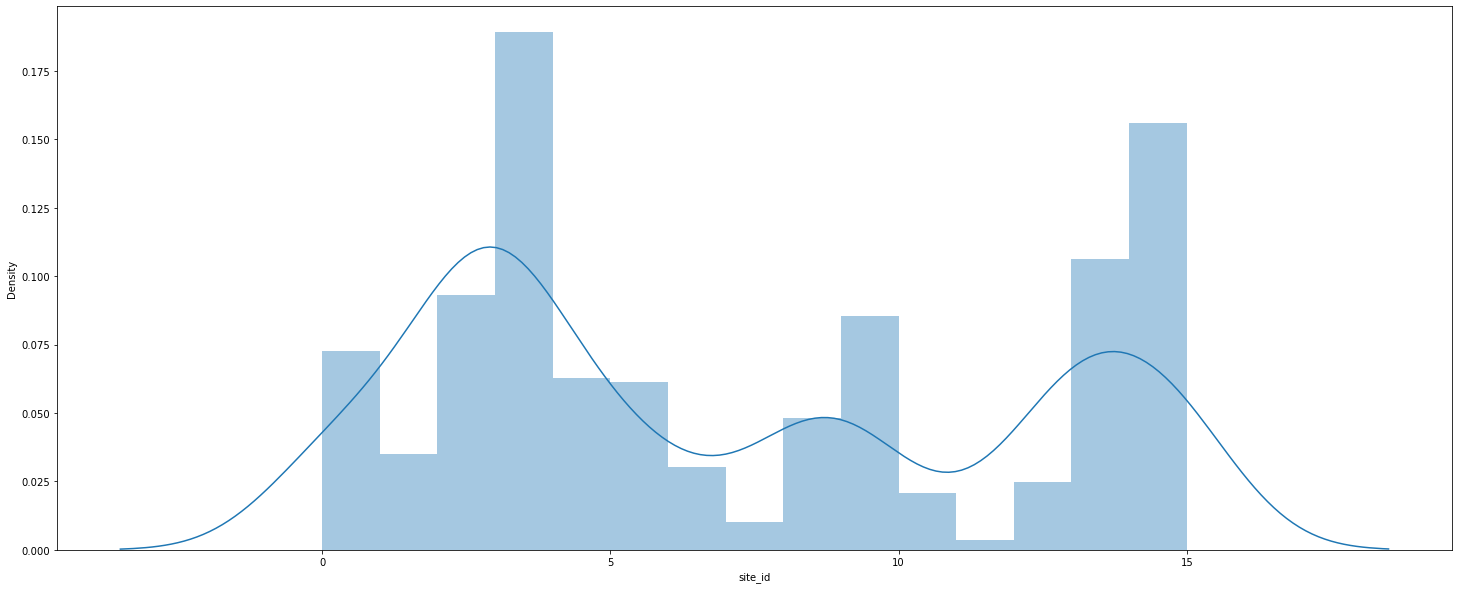

In [ ]:
plt.figure(figsize=[25,10])
sns.distplot(building_meta['site_id'], bins=15)

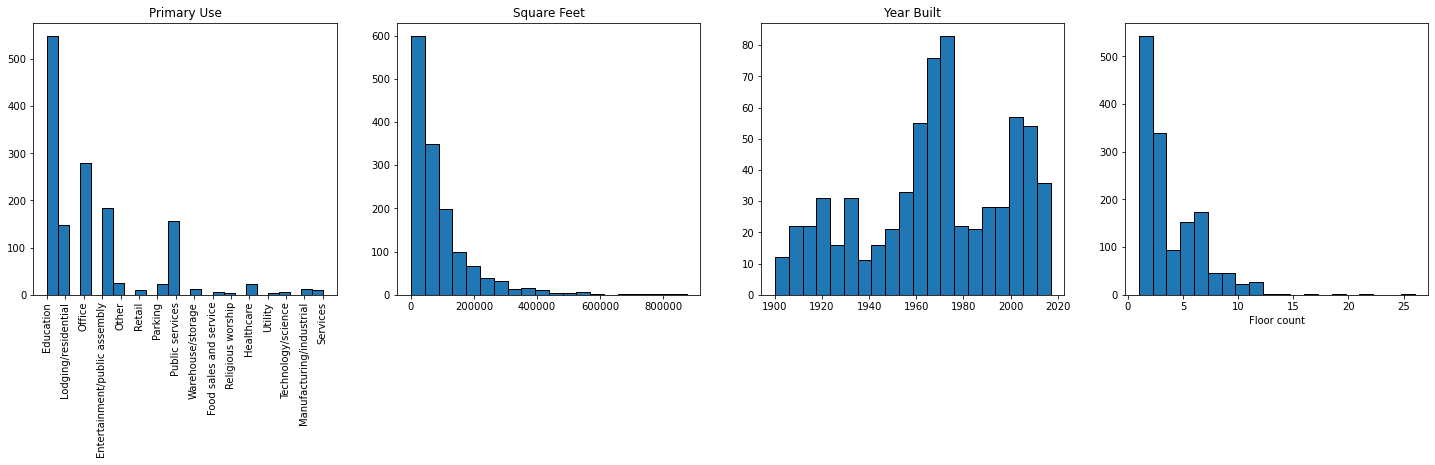

In [ ]:
#Distribution of other features
plt.figure(figsize=[25,5])
plt.xticks(fontsize=14)
plt.subplot(1,4,1)
plt.title("Primary Use")
plt.hist(building_meta['primary_use'],bins=25,ec="black")
plt.xticks(rotation=90)
plt.subplot(1,4,2)
plt.title("Square Feet")
plt.hist(building_meta['square_feet'],bins=20,edgecolor='white',ec="black")
plt.subplot(1,4,3)
plt.title("Year Built")
plt.hist(building_meta['year_built'],bins=20,ec="black")
plt.subplot(1,4,4)
plt.xlabel('Floor count')
plt.hist(building_meta['floor_count'],bins=20,edgecolor='white',ec="black")
plt.show()

#We get that there are 16 types of building that are mostly built after the 1950s
#and most buildings are small comparing to the left most side as they are logarithmically distributed.

In [ ]:
#Finding correlations between features
building_meta.corr()

,site_id,building_id,square_feet,year_built,floor_count
site_id,1.000000,0.977283,0.082136,-0.187021,-0.556843
building_id,0.977283,1.000000,0.074312,-0.230185,-0.585243
square_feet,0.082136,0.074312,1.000000,0.109063,0.311292
year_built,-0.187021,-0.230185,0.109063,1.000000,0.169720
floor_count,-0.556843,-0.585243,0.311292,0.169720,1.000000


<AxesSubplot:>

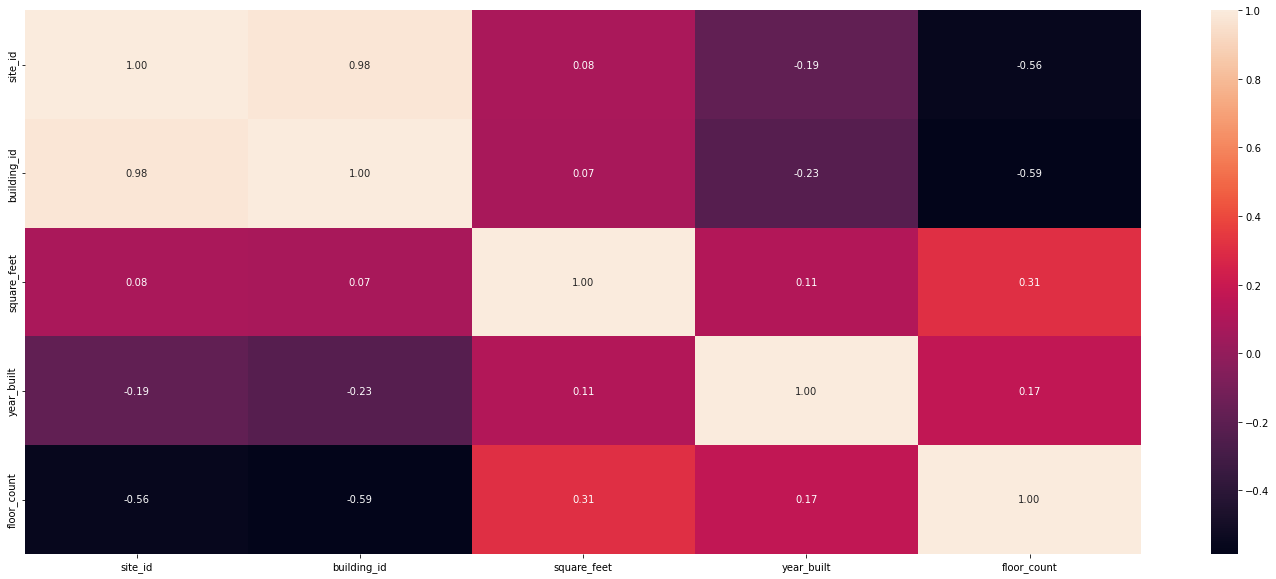

In [ ]:
plt.figure(figsize=(25,10))
sns.heatmap(building_meta.corr(), annot=True, fmt=".2f")


### From the above heatmap it can be concluded that the problem of multicolinearity exits in the dataframe, however for now no column will be dropped until the train dataframe is merged and the correlation between the variables and the target variable studied

## Train Data

In [ ]:
train.head()
#We see that this data contains our target variable (meter_reading) that is identified by 
#and a relation with building meta data (building_id)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [ ]:
train.shape

(20216100, 4)

In [ ]:
#We find here that there are no missing data.
pd.isnull(train).sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [ ]:
#Finding total readings of each building and the correlations with other features.
total_meter_readings = train[['building_id', 'meter_reading']].groupby('building_id').sum()
total_meter_readings = building_meta.merge(total_meter_readings, on='building_id')
total_meter_readings.rename(columns={'meter_reading': 'total_meter_readings'}, inplace=True)
total_meter_readings.head(10)

,site_id,building_id,primary_use,square_feet,year_built,floor_count,total_meter_readings
0,0,0,Education,7432,2008.0,5,1.286461e+06
1,0,1,Education,2720,2004.0,5,6.576176e+05
2,0,2,Education,5376,1991.0,5,1.278194e+05
3,0,3,Education,23685,2002.0,6,2.069071e+06
4,0,4,Education,116607,1975.0,8,8.578074e+06
5,0,5,Education,8000,2000.0,5,1.571848e+05
6,0,6,Lodging/residential,27926,1981.0,9,5.627611e+05
7,0,7,Education,121074,1989.0,9,2.558355e+07
8,0,8,Education,60809,2003.0,6,2.256854e+06
9,0,9,Office,27000,2010.0,6,5.468687e+06


<AxesSubplot:xlabel='building', ylabel='total meter reading'>

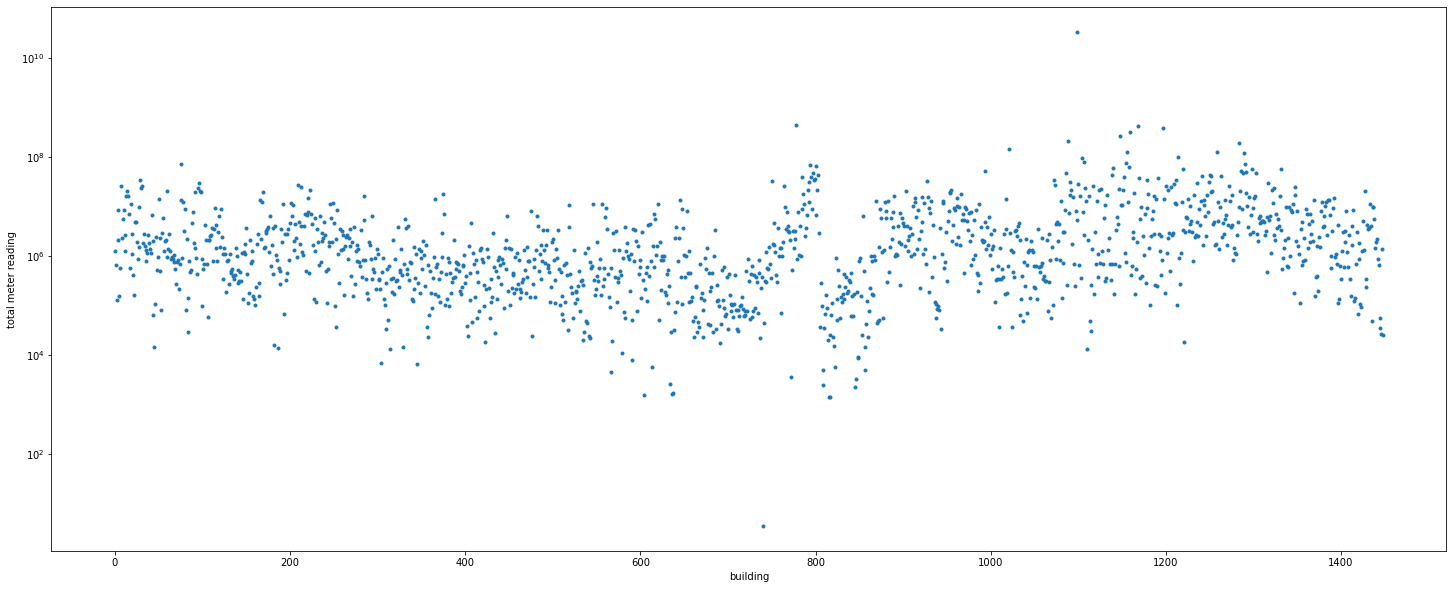

In [ ]:
plt.figure(figsize=(25,10))
total_meter_readings['total_meter_readings'].plot(logy=True,style='.', xlabel="building", ylabel="total meter reading")
#We find here that there are two points that are far away from the other points which might affect our predictions 
#that are considered as outlines hence,these points shall be removed.

In [ ]:
minPoint = total_meter_readings.total_meter_readings.sort_values(ascending=True).index[0]
maxPoint = total_meter_readings.total_meter_readings.sort_values(ascending=True).index[-1]
total_meter_readings[(total_meter_readings.index==minPoint)|(total_meter_readings.index==maxPoint)]

,site_id,building_id,primary_use,square_feet,year_built,floor_count,total_meter_readings
740,5,740,Education,37975,1976.0,1,3.513400e+00
1099,13,1099,Education,332884,NaN,3,3.350620e+10


<AxesSubplot:>

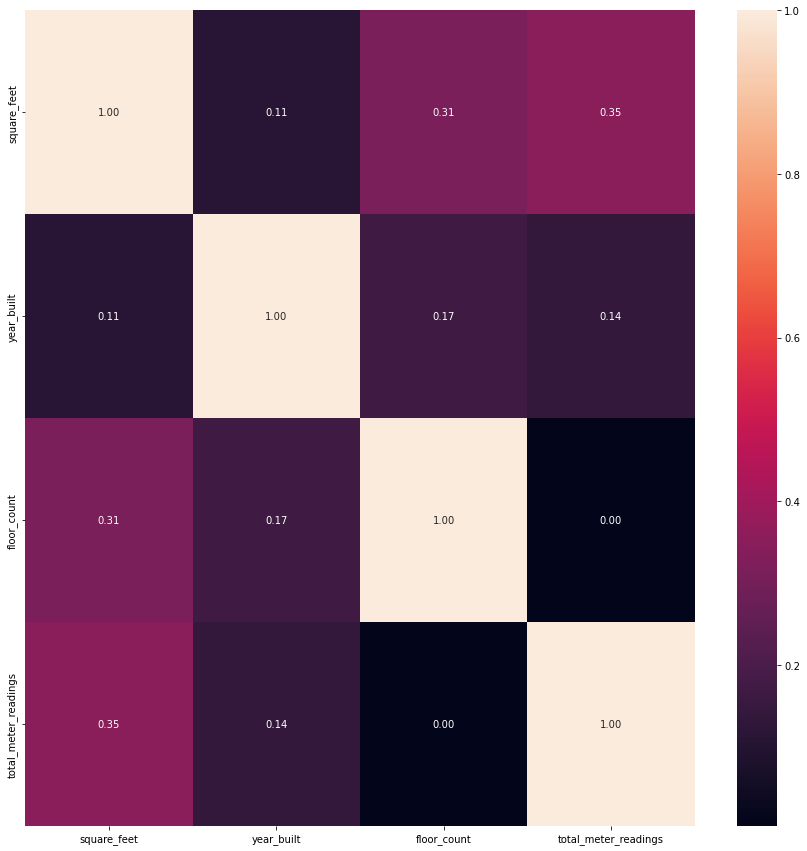

In [ ]:
#Now let us explore the correlation between meter readings and the other features.
# total_meter_readings[(total_meter_readings.index!=minPoint) &(total_meter_readings.index!=maxPoint)][['square_feet', 'year_built', 'floor_count', 'total_meter_readings']].corr()
#We find the total meter_readings have the strongest correlation with square feet and least with year_built.

plt.figure(figsize=(15,15))
sns.heatmap(total_meter_readings[(total_meter_readings.index!=minPoint) &(total_meter_readings.index!=maxPoint)][['square_feet', 'year_built', 'floor_count', 'total_meter_readings']].corr(), annot=True, fmt=".2f")

### As it can be seen in the above heatmap the correlation between the target variable (total_meter_reading) and floor count is exactly 0, hence it will be removed from the dataframe

In [ ]:
trainMergeBuilding = building_meta.merge(train, on='building_id')
trainMergeBuilding['timestamp'] = pd.to_datetime(trainMergeBuilding['timestamp'])
trainMergeBuilding.head(10)

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,timestamp,meter_reading
0,0,0,Education,7432,2008.0,5,0,2016-01-01 00:00:00,0.0
1,0,0,Education,7432,2008.0,5,0,2016-01-01 01:00:00,0.0
2,0,0,Education,7432,2008.0,5,0,2016-01-01 02:00:00,0.0
3,0,0,Education,7432,2008.0,5,0,2016-01-01 03:00:00,0.0
4,0,0,Education,7432,2008.0,5,0,2016-01-01 04:00:00,0.0
5,0,0,Education,7432,2008.0,5,0,2016-01-01 05:00:00,0.0
6,0,0,Education,7432,2008.0,5,0,2016-01-01 06:00:00,0.0
7,0,0,Education,7432,2008.0,5,0,2016-01-01 07:00:00,0.0
8,0,0,Education,7432,2008.0,5,0,2016-01-01 08:00:00,0.0
9,0,0,Education,7432,2008.0,5,0,2016-01-01 09:00:00,0.0


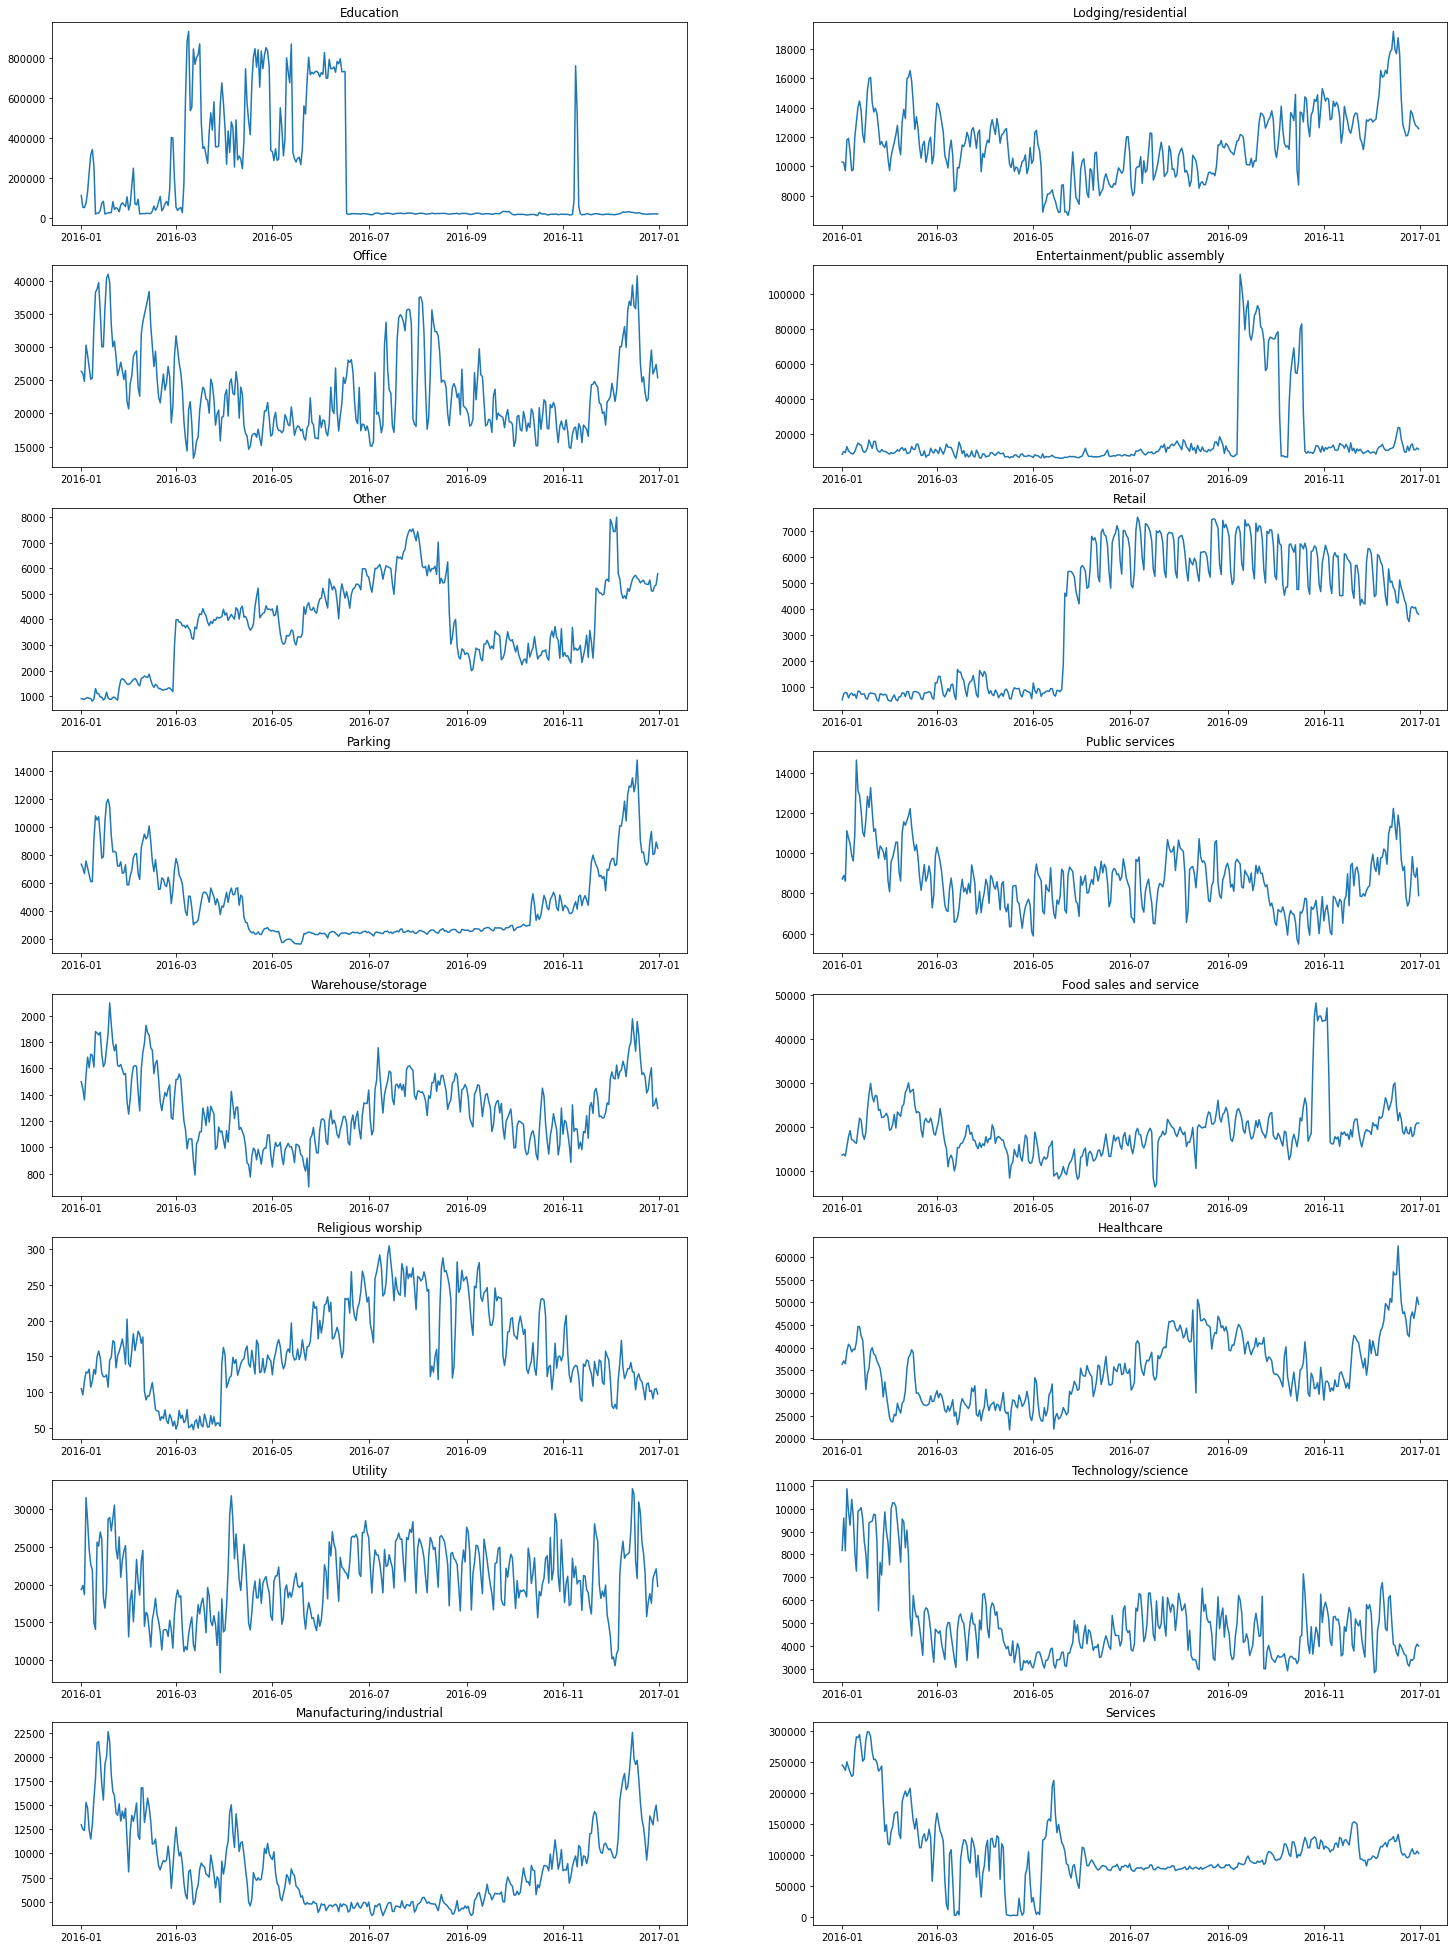

In [ ]:
# Here we explore the average meter readings in a timeline per building type.
primary_use_list = trainMergeBuilding['primary_use'].unique()
primary_use_dfs = [trainMergeBuilding[trainMergeBuilding['primary_use']==use] for use in primary_use_list]
plt.figure(figsize=[25,35])
plot_index = 1
plt.subplot(8,2,1)

for df in primary_use_dfs:
    plt.title(df['primary_use'].unique()[0])
    prim_use_daily = df.groupby(['building_id', df['timestamp'].dt.date])['meter_reading'].sum()
    prim_use_daily = prim_use_daily.reset_index()
    mean = prim_use_daily.groupby('timestamp')['meter_reading'].mean()
    plt.plot(mean.index, mean)
    plot_index = plot_index + 1 if plot_index < 16 else 1
    plt.subplot(8,2,plot_index)


# The data shown is as expected but in Education the outline is shown as follows hence, it will be removed.

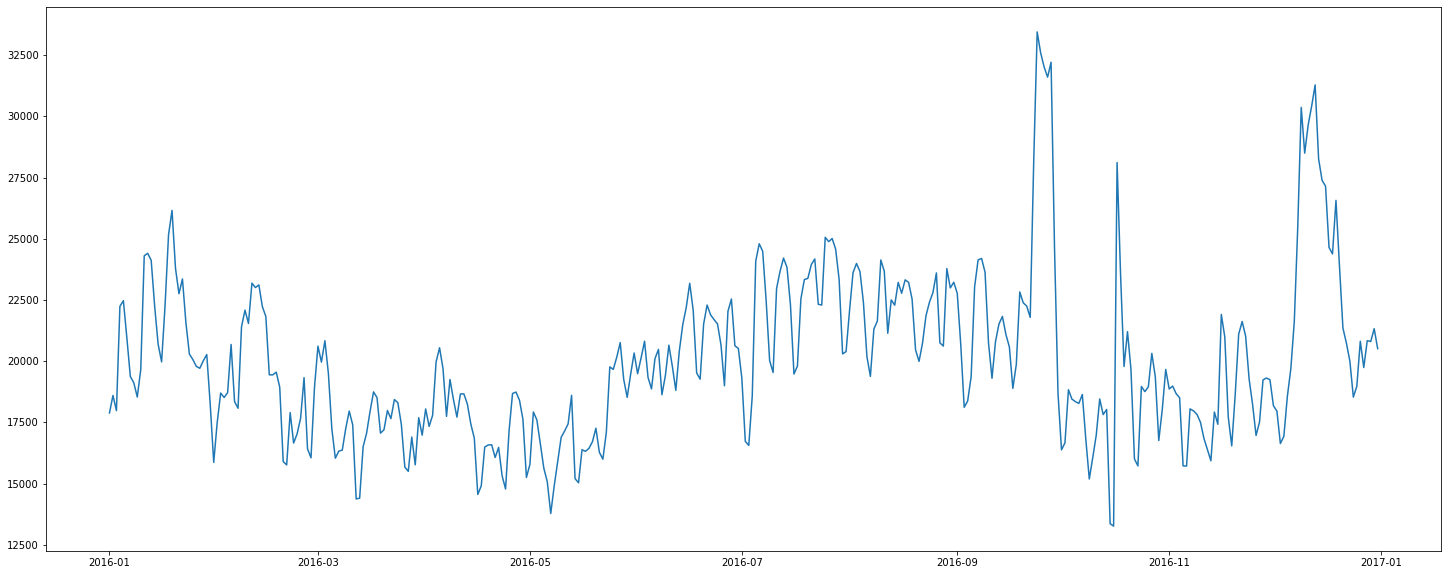

In [ ]:
edu_df = trainMergeBuilding[(trainMergeBuilding['primary_use']=='Education')&(trainMergeBuilding['building_id']!=minPoint)&(trainMergeBuilding['building_id']!=maxPoint)]
edu_daily = edu_df.groupby(['building_id', edu_df['timestamp'].dt.date])['meter_reading'].sum()
edu_daily = edu_daily.reset_index()
edu_mean = edu_daily.groupby('timestamp')['meter_reading'].mean()
# axes[0, 0].plot(edu_mean.index, edu_mean)
# axes[0, 0].set_title('Education With No Outliers')
mean = edu_daily.groupby('timestamp')['meter_reading'].mean()
plt.figure(figsize=[25,10])
plt.plot(mean.index, mean)
plt.show()

In [ ]:
trainNoOutlier = trainMergeBuilding[(trainMergeBuilding['building_id']!=minPoint)&(trainMergeBuilding['building_id']!=maxPoint)]

In [ ]:
trainNoOutlier.isnull().sum()

site_id                 0
building_id             0
primary_use             0
square_feet             0
year_built       12110079
floor_count             0
meter                   0
timestamp               0
meter_reading           0
dtype: int64

In [ ]:
trainNoOutlier.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,timestamp,meter_reading
0,0,0,Education,7432,2008.0,5,0,2016-01-01 00:00:00,0.0
1,0,0,Education,7432,2008.0,5,0,2016-01-01 01:00:00,0.0
2,0,0,Education,7432,2008.0,5,0,2016-01-01 02:00:00,0.0
3,0,0,Education,7432,2008.0,5,0,2016-01-01 03:00:00,0.0
4,0,0,Education,7432,2008.0,5,0,2016-01-01 04:00:00,0.0


## Weather Data

In [ ]:
# We see that weather train has an hourly data and contains Null values
weather_train.head(10)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
5,0,2016-01-01 05:00:00,19.4,NaN,19.4,0.0,NaN,0.0,0.0
6,0,2016-01-01 06:00:00,21.1,6.0,21.1,-1.0,1019.4,0.0,0.0
7,0,2016-01-01 07:00:00,21.1,NaN,21.1,0.0,1018.8,210.0,1.5
8,0,2016-01-01 08:00:00,20.6,NaN,20.0,0.0,1018.1,0.0,0.0
9,0,2016-01-01 09:00:00,21.1,NaN,20.6,0.0,1019.0,290.0,1.5


In [ ]:
weather_train.isnull().sum() / len(weather_train)

site_id               0.000000
timestamp             0.000000
air_temperature       0.000393
cloud_coverage        0.494895
dew_temperature       0.000808
precip_depth_1_hr     0.359791
sea_level_pressure    0.075966
wind_direction        0.044844
wind_speed            0.002175
dtype: float64

## Checking for missing values, duplicates and overall problems in the weather dataframe

In [ ]:
# The weather data is orgainzed according to the site id in which each site has a full year of data.
# first we will check for missing data and overall problems with the data.

number_of_sites = weather_train['site_id'].nunique()

expected_number_of_rows_per_site = ((weather_train.timestamp.max() - weather_train.timestamp.min()).total_seconds() + 3600) /3600
expected_number_of_rows = number_of_sites * expected_number_of_rows_per_site
actual_number_of_rows = weather_train.shape[0]

print("Number of sites: {}".format(number_of_sites))
print("Expected number of rows per site: {}".format(expected_number_of_rows_per_site))
print("Expected number of rows: {}".format(expected_number_of_rows))
print("Actual number of rows: {}".format(actual_number_of_rows))


Number of sites: 16
Expected number of rows per site: 8784.0
Expected number of rows: 140544.0
Actual number of rows: 139773


## From the above we can conclude that there are missing hours in the data as the number of rows do not equal the expected number of rows

In [ ]:
# To fill the missing hours we first need to split the weather data into separate dataframes for each site, as the missing hours and missing data are site specific.
# Then we will fill the missing hours and missing data for each site separately.

def data_frame_splitter(df):
    site_dfs = []
    for site_id in range(number_of_sites):
        site_df = df[df['site_id']==site_id]
        site_df = site_df.set_index('timestamp')
        site_dfs.append(site_df)
    return site_dfs

site_dfs_train = data_frame_splitter(weather_train)
for df in site_dfs_train:
    print(df.shape, df.site_id[0])

(8784, 8) 0
(8763, 8) 1
(8783, 8) 2
(8780, 8) 3
(8783, 8) 4
(8755, 8) 5
(8782, 8) 6
(8614, 8) 7
(8784, 8) 8
(8780, 8) 9
(8782, 8) 10
(8614, 8) 11
(8755, 8) 12
(8783, 8) 13
(8777, 8) 14
(8454, 8) 15


## From the above we can conclude that only site 0 and site 8 have their full hours, but it still has null values which need to be dealt with

In [ ]:
## First we will add the missing hours to the dataframes, for now these new rows will hold only NaN values.

def add_missing_hours(site_dfs, expected_number_of_rows_per_site):
    for site_df in site_dfs:
        if (site_df.shape[0] < expected_number_of_rows_per_site):
            missing_hours = pd.date_range(start=site_df.index.min(), end=site_df.index.max(), freq='H', closed='left')
            missing_hours = missing_hours.difference(site_df.index)
            for hour in missing_hours:
                site_df.loc[hour] = np.nan
    return site_dfs


site_dfs = add_missing_hours(site_dfs_train, expected_number_of_rows_per_site)

for df in site_dfs:
    print(df.shape)



(8784, 8)
(8784, 8)
(8784, 8)
(8784, 8)
(8783, 8)
(8783, 8)
(8783, 8)
(8784, 8)
(8784, 8)
(8783, 8)
(8783, 8)
(8784, 8)
(8784, 8)
(8784, 8)
(8783, 8)
(8783, 8)


In [ ]:
# Now lets fill the NaN values in each dataframe using interpolation.


def fill_missing_data(site_dfs, cols):

    for site_df in site_dfs:
        for col in cols:

            # first lets check if the first entry in a column is a NaN value, if so we will fill it with the next value, as this may make the interpolation fail.
            if (pd.isnull(site_df[col][0])):
                if(site_df[col].isnull().sum() > 8000):
                    site_df[col].fillna(weather_train[col].mean(), inplace=True)
                    continue
                else:
                    site_df[col][0] = site_df[col].mean()

            # Now lets interpolate the missing values
            site_df[col] = site_df[col].interpolate(method='polynomial', order=2)

    # Now we will stitch the dataframes back together and sort them by timestamp.
    df_final = pd.concat(site_dfs)
    df_final = df_final.reset_index()
    df_final = df_final.sort_values(by='timestamp')
    df_final = df_final.reset_index(drop=True)
    return df_final

weather_train_final = fill_missing_data(site_dfs, site_dfs[0].columns)

In [ ]:
weather_train_final.fillna(weather_train_final.mean(), inplace=True)

In [ ]:
# Now lets make sura that all missing values are filled
weather_train_final.isnull().sum() / len(weather_train_final)

timestamp             0.0
site_id               0.0
air_temperature       0.0
cloud_coverage        0.0
dew_temperature       0.0
precip_depth_1_hr     0.0
sea_level_pressure    0.0
wind_direction        0.0
wind_speed            0.0
dtype: float64

## Since that the weather_test dataframe has the same problems as the weather_train dataframe we will need to do the same operations on this dataframe as we did on the previous.

In [ ]:
#fixing the problems with the weather test data

expected_number_of_rows_per_site_test = ((weather_test.timestamp.max() - weather_test.timestamp.min()).total_seconds() + 3600) /3600

site_dfs_test = data_frame_splitter(weather_test)
site_dfs_test = add_missing_hours(site_dfs_test, expected_number_of_rows_per_site_test)
weather_test_final = fill_missing_data(site_dfs_test, site_dfs_test[0].columns)
weather_test_final.fillna(weather_test_final.mean(), inplace=True)
weather_test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280313 entries, 0 to 280312
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           280313 non-null  datetime64[ns]
 1   site_id             280313 non-null  float64       
 2   air_temperature     280313 non-null  float64       
 3   cloud_coverage      280313 non-null  float64       
 4   dew_temperature     280313 non-null  float64       
 5   precip_depth_1_hr   280313 non-null  float64       
 6   sea_level_pressure  280313 non-null  float64       
 7   wind_direction      280313 non-null  float64       
 8   wind_speed          280313 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 19.2 MB


In [ ]:
weather_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             277243 non-null  int64         
 1   timestamp           277243 non-null  datetime64[ns]
 2   air_temperature     277139 non-null  float64       
 3   cloud_coverage      136795 non-null  float64       
 4   dew_temperature     276916 non-null  float64       
 5   precip_depth_1_hr   181655 non-null  float64       
 6   sea_level_pressure  255978 non-null  float64       
 7   wind_direction      264873 non-null  float64       
 8   wind_speed          276783 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 19.0 MB


In [ ]:
weather_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140537 entries, 0 to 140536
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           140537 non-null  datetime64[ns]
 1   site_id             140537 non-null  float64       
 2   air_temperature     140537 non-null  float64       
 3   cloud_coverage      140537 non-null  float64       
 4   dew_temperature     140537 non-null  float64       
 5   precip_depth_1_hr   140537 non-null  float64       
 6   sea_level_pressure  140537 non-null  float64       
 7   wind_direction      140537 non-null  float64       
 8   wind_speed          140537 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 9.7 MB


## Merging the dataframes together to get the final training data frame

In [ ]:
train_final = building_meta.merge(train, on='building_id').merge(weather_train_final, on=['site_id', 'timestamp'])
print(train_final.shape)
test_final = building_meta.merge(test, on='building_id').merge(weather_test_final, on=['site_id', 'timestamp'])
print(test_final.shape)
print(train_final.isnull().sum())

(20143114, 16)
(41535320, 16)
site_id                      0
building_id                  0
primary_use                  0
square_feet                  0
year_built            12117757
floor_count                  0
meter                        0
timestamp                    0
meter_reading                0
air_temperature              0
cloud_coverage               0
dew_temperature              0
precip_depth_1_hr            0
sea_level_pressure           0
wind_direction               0
wind_speed                   0
dtype: int64


In [ ]:
train_final = train_final[(train_final['building_id']!=minPoint)&(train_final['building_id']!=maxPoint)]
train_final['meter_reading'] = np.log1p(train_final['meter_reading'])
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20116790 entries, 0 to 20143113
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   site_id             int64         
 1   building_id         int64         
 2   primary_use         object        
 3   square_feet         int64         
 4   year_built          float64       
 5   floor_count         int64         
 6   meter               int64         
 7   timestamp           datetime64[ns]
 8   meter_reading       float64       
 9   air_temperature     float64       
 10  cloud_coverage      float64       
 11  dew_temperature     float64       
 12  precip_depth_1_hr   float64       
 13  sea_level_pressure  float64       
 14  wind_direction      float64       
 15  wind_speed          float64       
dtypes: datetime64[ns](1), float64(9), int64(5), object(1)
memory usage: 2.5+ GB


In [ ]:
print(train_final.shape)
print(test_final.shape)
print(train_final['primary_use'])

(20116790, 16)
(41535320, 16)
0                     Education
1                     Education
2                     Education
3                     Education
4                     Education
                   ...         
20143109    Lodging/residential
20143110    Lodging/residential
20143111    Lodging/residential
20143112    Lodging/residential
20143113    Lodging/residential
Name: primary_use, Length: 20116790, dtype: object


In [ ]:
#Fill in missing year_built with the mean of other buildings in the same site; 
#if none of the buildings in a site has year_built, then fill with the mean of the entire dataset
year_built_gp = building_meta.groupby('site_id')['year_built']
building_meta['year_built'] = year_built_gp.transform(lambda x: x.fillna(x.mean()))
building_meta['year_built'].fillna(np.nanmean(building_meta['year_built']), inplace=True)
assert pd.isnull(building_meta['year_built']).sum() == 0


### One last look before preparations for the models

In [ ]:
train_final.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,Education,7432,2008.0,5,0,2016-01-01,0.0,25.0,6.0,20.0,1.382557,1019.7,0.0,0.0
1,0,1,Education,2720,2004.0,5,0,2016-01-01,0.0,25.0,6.0,20.0,1.382557,1019.7,0.0,0.0
2,0,2,Education,5376,1991.0,5,0,2016-01-01,0.0,25.0,6.0,20.0,1.382557,1019.7,0.0,0.0
3,0,3,Education,23685,2002.0,6,0,2016-01-01,0.0,25.0,6.0,20.0,1.382557,1019.7,0.0,0.0
4,0,4,Education,116607,1975.0,8,0,2016-01-01,0.0,25.0,6.0,20.0,1.382557,1019.7,0.0,0.0


<AxesSubplot:>

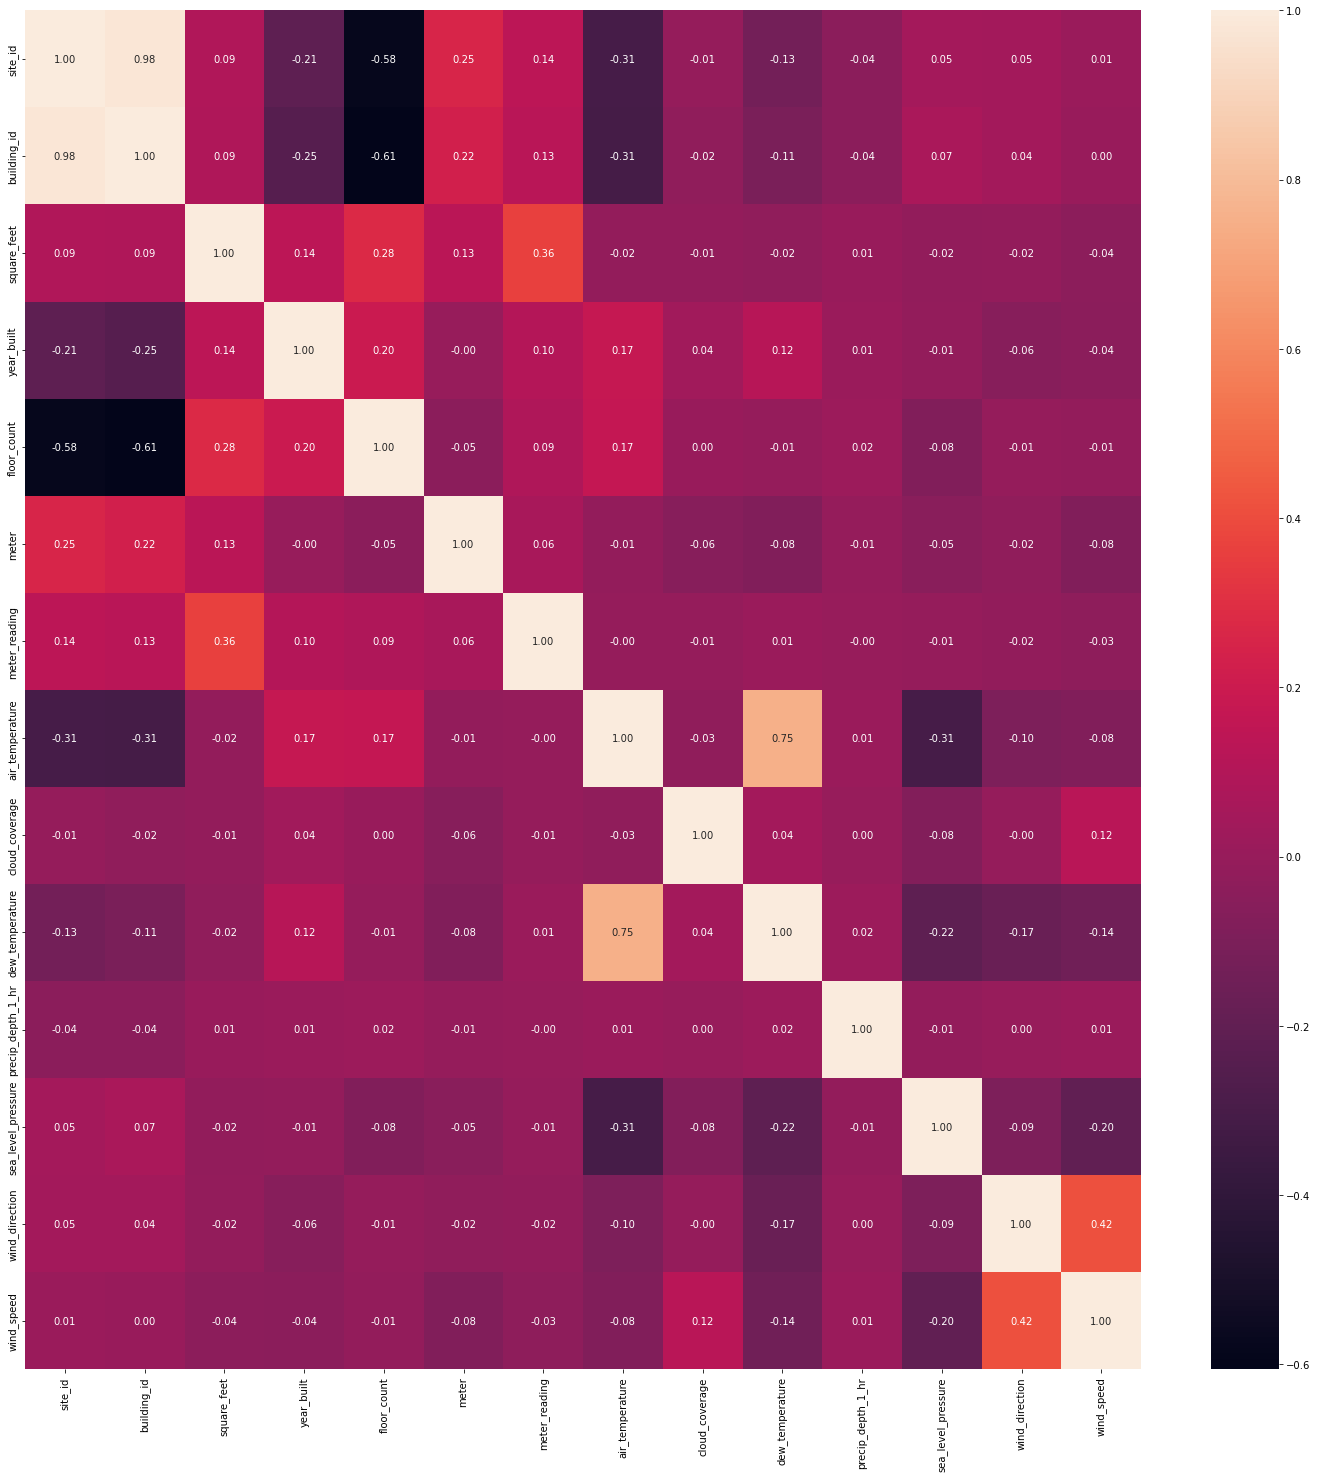

In [ ]:
plt.figure(figsize=(25,25))
sns.heatmap(train_final.corr(), annot=True, fmt=".2f")

In [ ]:
meter_reading = train_final['meter_reading']
features = train_final.drop(['meter_reading','year_built','floor_count','building_id', 'wind_direction'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, meter_reading, test_size = 0.25)


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
numbers  = X_train.select_dtypes(include=[np.number])
num_attribs = list(numbers)
cat_attribs =['primary_use']

In [ ]:
num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
    ('selector', OldDataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
    ])
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
     ])
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.fit_transform(X_test)
print(X_train)
print("..........")
print(X_test)


[[ 1.18386444 -0.1810503   0.36307012 ...  0.          0.
   0.        ]
 [-0.77921491  0.1957028  -0.71093442 ...  0.          0.
   0.        ]
 [-1.56444665 -0.40617492 -0.71093442 ...  0.          0.
   0.        ]
 ...
 [-0.77921491 -0.56661473 -0.71093442 ...  0.          0.
   0.        ]
 [-0.97552285 -0.66306988 -0.71093442 ...  0.          0.
   0.        ]
 [ 1.38017237 -0.16805528  1.43707465 ...  0.          0.
   0.        ]]
..........
[[-1.17091518 -0.60872728 -0.71063914 ...  0.          0.
   0.        ]
 [ 0.79278735 -0.44285373 -0.71063914 ...  0.          0.
   0.        ]
 [-0.97454493 -0.84259582 -0.71063914 ...  0.          0.
   0.        ]
 ...
 [-1.17091518 -0.10145048  2.51154144 ...  0.          0.
   0.        ]
 [-0.38543417 -0.65897515  0.36342105 ...  0.          0.
   0.        ]
 [ 1.3818981  -0.83840493 -0.71063914 ...  0.          0.
   0.        ]]


In [ ]:
sgdr = SGDRegressor(penalty='l2',  alpha=1, max_iter=1000, early_stopping=False, learning_rate='invscaling', eta0=0.01)
sgdr.fit(X_train, y_train.values)
y_pred_lr = sgdr.predict(X_test)
print(np.sqrt(mean_squared_log_error( y_test, y_pred_lr )))
print(np.expm1(y_pred_lr))

0.5989323416257641
[40.04298752 62.99215918 38.80482236 ... 55.56397035 48.49246693
 59.18263073]


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train.values)
y_pred_lr = lin_reg.predict(X_test)
print(np.sqrt(mean_squared_error( y_test, y_pred_lr )))
print(np.expm1(y_pred_lr))

1.9508226087728375
[26.69095864 67.082376   26.51952162 ... 45.97327662 41.44070436
 58.39428431]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10, random_state=7, n_jobs=-1, max_depth=100)
model.fit(X_train, y_train.values)
y_pred_lr = model.predict(X_test)
print(np.sqrt(mean_squared_log_error( y_test, y_pred_lr )))
print(np.expm1(y_pred_lr))

: 

: 

In [ ]:
# catboost model
from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=100, loss_function='RMSE', eval_metric='RMSE')
model.fit(X_train, y_train.values)
y_pred_lr = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_lr)))
r2 = r2_score(y_test, y_pred_lr)
print("Testing performance")
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))
# print(np.sqrt(mean_squared_log_error( y_test, y_pred_lr )))
print(f"The mean absolute error (MAE) on test set: {mean_absolute_error(y_test, y_pred_lr)}")
print(np.expm1(y_pred_lr))



0:	learn: 2.1314188	total: 930ms	remaining: 2h 34m 57s
1:	learn: 2.1234413	total: 1.51s	remaining: 2h 5m 40s
2:	learn: 2.1155752	total: 2.14s	remaining: 1h 58m 40s
3:	learn: 2.1078692	total: 2.76s	remaining: 1h 55m 2s
4:	learn: 2.1002941	total: 3.3s	remaining: 1h 50m
5:	learn: 2.0928920	total: 3.83s	remaining: 1h 46m 17s
6:	learn: 2.0855477	total: 4.36s	remaining: 1h 43m 37s
7:	learn: 2.0782579	total: 4.87s	remaining: 1h 41m 20s
8:	learn: 2.0711149	total: 5.38s	remaining: 1h 39m 37s
9:	learn: 2.0641407	total: 5.9s	remaining: 1h 38m 14s
10:	learn: 2.0573061	total: 6.44s	remaining: 1h 37m 25s
11:	learn: 2.0504707	total: 6.97s	remaining: 1h 36m 40s
12:	learn: 2.0438409	total: 7.49s	remaining: 1h 35m 56s
13:	learn: 2.0371350	total: 8.03s	remaining: 1h 35m 24s
14:	learn: 2.0306090	total: 8.55s	remaining: 1h 34m 50s
15:	learn: 2.0241625	total: 9.07s	remaining: 1h 34m 18s
16:	learn: 2.0178472	total: 9.61s	remaining: 1h 34m 2s
17:	learn: 2.0115836	total: 10.1s	remaining: 1h 33m 41s
18:	learn: 